In [16]:
# referenced from https://qiita.com/takubb/items/7d45ae701390912c7629
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [17]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
# データセットの作成
trans = transforms.Compose([
    transforms.ToTensor()
])

class FocusPatchDataset(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, DIR, imsize, psize, channels, DEPTH_GAP, n_sample, transforms):
        
        # ground truth depthを読み込むdd
        with open(os.path.join(DIR,'depth.pkl'),"rb") as f:
            self.gt = pickle.load(f)
        
        if self.gt is None:
            print('cannot find ', os.path.join(DIR,'depth.pkl'))
            return None
        
        self.files = glob.glob(os.path.join(DIR,'[0-9]*.bmp'))
        # print(self.files)
        self.fvalues = []
        for fn in self.files:
            self.fvalues.append(int(os.path.splitext(os.path.basename(fn))[0]))
        self.fvalues.sort()
        
        self.DIR = DIR
        self.DEPTH_GAP = DEPTH_GAP
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        self.n_sample = n_sample

        self.imsize = imsize
        self.psize = psize
        self.locs = []

        # サンプル対象となる点を設定する
        w = imsize[0]
        h = imsize[1]        
        for i in range(self.n_sample):
            xx = random.randint(0,w-self.psize-1)
            yy = random.randint(0,h-self.psize-1)
            self.locs.append([xx,yy])

        print('locations', self.locs)
    
    def __len__(self):
        length = (len(self.fvalues) - self.DEPTH_GAP)*self.n_sample
        return length

    def __getitem__(self, index):
        imgs = []

        # n: file (data) index, m: point index
        n = index // self.n_sample
        m = index % self.n_sample

        x = self.locs[m][0]
        y = self.locs[m][1]
        
        val = float(self.gt[y,x]) - float(self.fvalues[n])

        FILE1 = os.path.join(self.DIR,f'{self.fvalues[n]:04d}.bmp')
        FILE2 = os.path.join(self.DIR,f'{self.fvalues[n+self.DEPTH_GAP]:04d}.bmp')

        # print(self.gt[y,x], self.fvalues[n], val, FILE1, FILE2, x, y)
        
        img = Image.open(FILE1)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)

        img = Image.open(FILE2)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)
        
        out = np.stack(imgs,axis=2)
        #print(out.shape)
        
        return self.transforms(out), val

In [19]:
PSIZE = 65
DEPTH_GAP = 100
N_SAMPLE = 20
dataset = FocusPatchDataset(DIR = 'data/202410080808', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=N_SAMPLE, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)

locations [[1162, 654], [616, 222], [311, 727], [1208, 149], [879, 227], [1482, 293], [343, 203], [46, 639], [228, 88], [977, 432], [727, 521], [1227, 836], [985, 34], [87, 617], [1360, 425], [708, 781], [1389, 51], [630, 786], [646, 533], [1322, 583]]


In [20]:
train_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.3])
len(dataset)

6020

In [21]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=256,  # バッチサイズ
                                           shuffle=True,  # データシャッフル
                                           num_workers=0,  # 高速化
                                           pin_memory=True  # 高速化                                      
                                           )
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=0,  # 高速化
                                          pin_memory=True  # 高速化                                                   
                                          )

In [23]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
# model = RESNETLIKE(channels=2).to(device)
model = MyModel(channels=2)
#model = MyModel_shallow(channels=2).to(device)
weight_file = f"weights/weight_{PSIZE}_{DEPTH_GAP}.pth"

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    print("load weight", weight_file)
    model.load_state_dict(torch.load(weight_file))
    model.eval()

model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters())

load weight weights/weight_65_100.pth


In [24]:
# モデル訓練関数
def train_model(model, train_loader, test_loader):
    # Train loop ----------------------------
    model.train()  # 学習モードをオン
    train_batch_loss = []
    for data, val in train_loader:
        # GPUへの転送
        data, val = data.to(device), val.to(device)
        # 1. 勾配リセット
        optimizer.zero_grad()
        # 2. 推論
        output = model(data)
        val = val.unsqueeze(1).to(torch.float32)
        # 3. 誤差計算
        loss = criterion(output, val)
        # 4. 誤差逆伝播
        loss.backward()
        # 5. パラメータ更新
        optimizer.step()
        # train_lossの取得
        train_batch_loss.append(loss.item())

    # Test(val) loop ----------------------------
    model.eval()  # 学習モードをオフ
    test_batch_loss = []
    with torch.no_grad():  # 勾配を計算なし
        for data, val in test_loader:
            data, val = data.to(device), val.to(device)
            output = model(data)
            val = val.unsqueeze(1).to(torch.float32)
            loss = criterion(output, val)
            test_batch_loss.append(loss.item())

    return model, np.mean(train_batch_loss), np.mean(test_batch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 2163.555, Test loss: 1648.547
Train loss: 1154.421, Test loss: 1004.862
Train loss: 795.280, Test loss: 903.467
Train loss: 636.372, Test loss: 695.728
Train loss: 513.821, Test loss: 491.732
Train loss: 399.298, Test loss: 373.327
Train loss: 307.471, Test loss: 437.278
Train loss: 281.076, Test loss: 335.368
Train loss: 272.527, Test loss: 316.287
Train loss: 234.756, Test loss: 241.024
Train loss: 203.781, Test loss: 243.013
Train loss: 216.145, Test loss: 220.142
Train loss: 185.996, Test loss: 209.304
Train loss: 183.019, Test loss: 190.299
Train loss: 170.309, Test loss: 209.475
Train loss: 173.911, Test loss: 210.946
Train loss: 187.938, Test loss: 239.391
Train loss: 158.495, Test loss: 197.263
Train loss: 137.321, Test loss: 152.418
Train loss: 139.506, Test loss: 257.908
Train loss: 184.723, Test loss: 184.824
Train loss: 144.217, Test loss: 166.214
Train loss: 126.705, Test loss: 155.962
Train loss: 141.906, Test loss: 208.659
Train loss: 145.859, Test loss: 156.

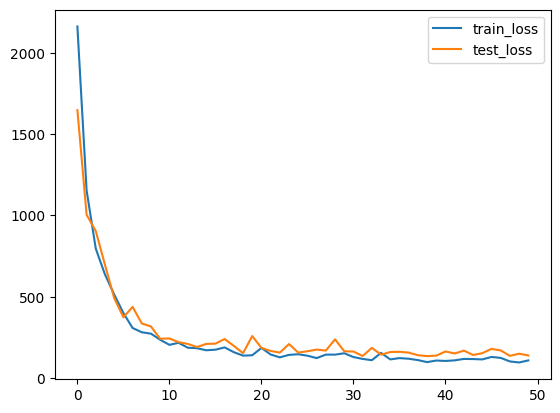

In [25]:
# 訓練の実行
epoch = 50
train_loss = []
test_loss = []

for epoch in tqdm(range(epoch)):
    model, train_l, test_l = train_model(model,train_loader,test_loader)
    train_loss.append(train_l)
    test_loss.append(test_l)    
    # 10エポックごとにロスを表示
    #if epoch % 5 == 0:
    print(f"Train loss: {train_loss[-1]:.3f}, Test loss: {test_loss[-1]:.3f}")

# 学習状況（ロス）の確認
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()

In [15]:
# モデルの保存
torch.save(model.state_dict(), weight_file)

In [12]:
# 学習済みモデルから予測結果と正解値を取得
def retrieve_result(model, dataloader):
    model.eval()
    preds = []
    labels = []
    # Retreive prediction and labels
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            # Collect data
            preds.append(output)
            labels.append(label)
    # Flatten
    preds = torch.cat(preds, axis=0)
    labels = torch.cat(labels, axis=0)
    # Returns as numpy (CPU環境の場合は不要)
    preds = preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return preds, labels


# データを作って評価してみる
dataset = FocusPatchDataset(DIR = 'data/202410041747-new', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=1, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)
preds, labels = retrieve_result(model, test_loader)

locations [[456, 575], [164, 193], [441, 361], [272, 362], [728, 420], [617, 330], [389, 121], [951, 350], [1130, 448], [48, 159], [986, 727], [1430, 211], [1369, 985], [81, 98], [974, 587], [1327, 872], [1386, 594], [1365, 886], [407, 258], [1286, 735], [158, 637], [551, 291], [1183, 722], [977, 227], [888, 108], [509, 181], [244, 372], [955, 714], [1203, 119], [1451, 723], [1000, 978], [1392, 236], [1247, 837], [1115, 123], [450, 252], [118, 919], [549, 560], [1127, 53], [689, 120], [549, 373], [713, 741], [1489, 465], [967, 819], [533, 150], [847, 944], [711, 761], [113, 764], [191, 535], [547, 529], [1138, 104], [1086, 676], [678, 765], [833, 546], [569, 1074], [1278, 171], [227, 620], [1521, 1124], [55, 393], [1425, 907], [1350, 221], [1114, 428], [1512, 960], [902, 1017], [1361, 778], [783, 733], [153, 852], [1247, 908], [1247, 42], [86, 979], [1498, 414], [709, 116], [338, 489], [672, 367], [772, 160], [245, 1025], [551, 433], [1084, 732], [819, 617], [371, 845], [1049, 774], [1

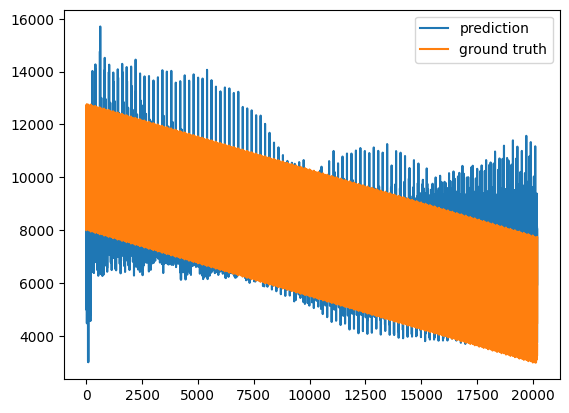

In [14]:
#for x,y in zip(preds,labels):
#    print(x,y,abs(x-y))
plt.plot(preds, label="prediction")
plt.plot(labels, label='ground truth')
plt.legend()